# World Data League 2021

## External links and resources

The only external data we've used was a [map of Oporto](https://raw.githubusercontent.com/fernandeslouro/wdl-data/main/map.png) caputured using [OpenStreetMaps' Export](https://www.openstreetmap.org/export#map=10/) function.

## Introduction
We're tring to solve the first problem - Predicting traffic flow in a city using induction loop sensors

Ou approach was to build a predictive model for future intensity of traffic. We believe a tool of this kind would be very useful to public officials, since it would allow for a proactive approach to traffic management. 

The data provided presents the traffic intensity in five minute intervals. However, we believe a model that offers predictions for 5 minute intervals is not very useful to public officials. We thought that predicting traffic intensity for subsequent days is likely more useful.

A good metric to predict for the next day would be the whole-day maximum intensity on a five-minute period, since this would give a good indication wheter traffic jams would occur. However, analysing the data, we find that it is common for the sensors to malfunction and provide inflated numbers for the count of cars, when analysing daily maximum numbers. We will therefore be predicting the mean number of cars, per five minute interval, per day.

Also, since our model depends on aggregate operations (mean of all 5-minute counts) from the previous day, we decided that we would instead predict the traffic in two days (rather than for the next day). This is because our model would offer predictions for the next day late into the night, which would not leave enough time to decide on and execute measures to fight traffic jams.

We noticed that after 10PM, and before 6AM, the number of cars tend to be much lower. Given that (barring special occasions like accidents, construction works or events) traffic jams do not tend to occur at night, we will predict the average cont of cards between 6AM and 10PM, for ach 5 minute time frame.

We'll call our dataframe "cc", a short name representing "Car Count".

## Development

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from datetime import timedelta
import datetime
import warnings
warnings.filterwarnings('ignore')
import requests
from PIL import Image
from io import BytesIO

In [2]:
# We found this code snipped online, to solve a problem we had when inporing the data through the links
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

### Importing data

In [3]:
#cc = pd.read_csv('traffic_flow_2021.csv', encoding = "ISO-8859-1")
cc = pd.read_csv('https://wdl-data.fra1.digitaloceanspaces.com/porto-digital/traffic_data/traffic_flow_2021.csv', encoding = "ISO-8859-1")

We will be treating this dataset as a time series. For that, we will drop some columns which we won't be using. We'll also simplify the name of the entities.

In [4]:
cc = cc.drop(columns=['dataprovider','source', 'entity_type', 'name', 'dateobservedto', 'laneid', 'lanedirection'])
cc.entity_id=cc.entity_id.str[52:]

In [5]:
cc.head(4)

,entity_id,dateobservedfrom,intensity,date_from,time_from
0,16Z2,2021-02-15 22:20:00,6,2021-02-15,22:20:00.0000000
1,4Z2,2021-02-15 22:20:00,10,2021-02-15,22:20:00.0000000
2,7Z8,2021-02-15 22:15:00,9,2021-02-15,22:15:00.0000000
3,9Z7,2021-01-28 13:15:00,12,2021-01-28,13:15:00.0000000


Since we'll only be predicting the mean number of cars during the day, we can exclude the data entries captured during the night time.

In [6]:
cc = cc[(cc.time_from <'22:00:00.0000000') & (cc.time_from >='06:00:00.0000000')]

We'll now group the count of cars by day. We'll calculate the mean for the considered period, for 5 minute windows. This column will represent the number of cars we can expect to have passed through the entity each five minutes, for each specific day. We'll call this dataframe 'dcc', for 'Daily Car Count'.

In [7]:
dcc = cc.groupby(['entity_id', 'date_from']).agg('mean').reset_index()

In [8]:
dcc

,entity_id,date_from,intensity
0,10Z2,2020-12-31,13.603774
1,10Z2,2021-01-01,5.083333
2,10Z2,2021-01-02,9.040984
3,10Z2,2021-01-03,7.702479
4,10Z2,2021-01-04,14.841667
...,...,...,...
8117,9Z9,2021-04-04,10.957895
8118,9Z9,2021-04-05,24.513514
8119,9Z9,2021-04-06,31.544974
8120,9Z9,2021-04-07,31.895833


There are some counters which seem to be broken, since they consistently provide very high car counts. We'll remove the top 4 sensors with highest average car counts from our dataframe, since those seemed to be completely broken.

In [9]:
ents_to_remove = dcc.groupby('entity_id').mean('intensity').sort_values('intensity', ascending=False).head(4).index.tolist()

In [10]:
ents_to_remove

['2Z8', '2Z9', '12Z3', '6Z2']

In [11]:
dcc = dcc[~dcc.entity_id.isin(ents_to_remove)]

### Weather Data

The weather is something that (often unconsciously) affects people's choices regarding traffic, so we'll use it in our model. However, Since we are making predictions for two days later, our model should ony be able to access weather data from two days before.

In [12]:
wt = pd.read_csv('weather_observed_2021.csv',  encoding = "ISO-8859-1")

We'll only use some of the features in the dataset, since some of the fields have many missing values. Given that we are making daily predictions, we'll compute the daily mean of the weather data. For simplicity, we are also averaging the data of all the sensors. Given that we are performing an analysis for a relatively small area, we'll use the mean values for every sensor. Even if the weather varies across parts of the city in some moments, people's intuititive perception of the weather should be more or less constant across the city.

In [13]:
weather = wt.groupby('observed_date')[['precipitation', 'relativehumidity', 'temperature', 'windspeed']].mean().reset_index()

In [14]:
weather['observed_date'] =  pd.to_datetime(weather['observed_date'], format='%Y-%m-%d')

In [15]:
weather_2d = weather.copy()

Again, we'll use the weather values of two days before.

In [16]:
weather_2d['observed_date'] = weather_2d['observed_date']+timedelta(2)

Since this weather information is from two days before the date in the index, we will change the column names to reflect that

In [17]:
weather_2d = weather_2d.rename(columns ={'precipitation': '2d_precipitation', 'relativehumidity':'2d_relativehumidity', 'temperature': '2d_temperature', 'windspeed':'2d_windspeed'} )

In [18]:
weather_2d['observed_date'] = weather_2d['observed_date'].astype(str)

In [19]:
weather_2d.head(4)

,observed_date,2d_precipitation,2d_relativehumidity,2d_temperature,2d_windspeed
0,2021-01-02,0.042417,0.963666,9.837122,1.550320
1,2021-01-03,0.003849,0.932737,6.598472,0.725139
2,2021-01-04,0.000307,0.935693,5.104826,0.528674
3,2021-01-05,0.006160,0.953861,5.045624,0.631756


We now merge the car counts data we have, with the weather data captured two days before. This way (other than the car counts, which we'll try and predict) each entry contains only information which would be accessible two days before the date.

In [20]:
dcc = pd.merge(dcc, weather_2d,
                    right_on=['observed_date'],left_on=['date_from'])

In [21]:
dcc.head(2)

,entity_id,date_from,intensity,observed_date,2d_precipitation,2d_relativehumidity,2d_temperature,2d_windspeed
0,10Z2,2021-01-02,9.040984,2021-01-02,0.042417,0.963666,9.837122,1.55032
1,10Z5,2021-01-02,2.095745,2021-01-02,0.042417,0.963666,9.837122,1.55032


# Features

There are two types of features which usually are very useful when trying to forecast time series: lags and differences.

Last-x-Day_Intensity: this is simply the amount of sales that a product had in the previous week  
Last Week Diff: the difference between the amount of sales in the previous week and the week before it (t-1 - t-2)

In [22]:
dcc2 = dcc.copy()
#dcc2['Previous_day_intensity'] = dcc2.groupby(['entity_id'])['intensity'].shift()
#dcc2['Previous_day_diff'] = dcc2.groupby(['entity_id'])['intensity'].diff()
dcc2['Last-1_Day_Intensity'] = dcc2.groupby(['entity_id'])['intensity'].shift(2)
dcc2['Last-1_Day_Diff'] = dcc2.groupby(['entity_id'])['Last-1_Day_Intensity'].diff()
dcc2['Last-2_Day_Intensity'] = dcc2.groupby(['entity_id'])['intensity'].shift(3)
dcc2['Last-2_Day_Diff'] = dcc2.groupby(['entity_id'])['Last-2_Day_Intensity'].diff()
dcc2['Last-3_Day_Intensity'] = dcc2.groupby(['entity_id'])['intensity'].shift(4)
dcc2['Last-3_Day_Diff'] = dcc2.groupby(['entity_id'])['Last-3_Day_Intensity'].diff()
dcc2 = dcc2.dropna()
dcc2.head()

,entity_id,date_from,intensity,observed_date,2d_precipitation,2d_relativehumidity,2d_temperature,2d_windspeed,Last-1_Day_Intensity,Last-1_Day_Diff,Last-2_Day_Intensity,Last-2_Day_Diff,Last-3_Day_Intensity,Last-3_Day_Diff
400,10Z2,2021-01-07,15.176000,2021-01-07,0.000123,0.907553,4.15691,0.563541,15.169118,0.327451,14.841667,7.139187,7.702479,-1.338504
401,10Z5,2021-01-07,6.428571,2021-01-07,0.000123,0.907553,4.15691,0.563541,6.722222,1.884384,4.837838,3.125194,1.712644,-0.383101
402,10Z8,2021-01-07,278.950000,2021-01-07,0.000123,0.907553,4.15691,0.563541,192.146341,66.021341,126.125000,54.411957,71.713043,-64.910888
403,10Z9,2021-01-07,70.133333,2021-01-07,0.000123,0.907553,4.15691,0.563541,68.572581,7.894009,60.678571,32.035093,28.643478,-4.783872
404,11Z1,2021-01-07,6.200000,2021-01-07,0.000123,0.907553,4.15691,0.563541,5.925373,0.110247,5.815126,2.713274,3.101852,-0.762555


# Evaluation Metric

To evaluate the quality of our predictions, we'll used the Root Mean Squared Log Error as our metric. This applies the RMSE to the log of the target and the prediction output. 

In [23]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

### Converting the entities to Integer

We'll use an implementation of 'two-way dicts' (bidirectional hash table) to keep information of pairs of entity_id-integer

In [24]:
class TwoWayDict(dict):
    def __setitem__(self, key, value):
        # Remove any previous connections with these values
        if key in self:
            del self[key]
        if value in self:
            del self[value]
        dict.__setitem__(self, key, value)
        dict.__setitem__(self, value, key)

    def __delitem__(self, key):
        dict.__delitem__(self, self[key])
        dict.__delitem__(self, key)

    def __len__(self):
        """Returns the number of connections"""
        return dict.__len__(self) // 2

In [25]:
d2n = TwoWayDict()
for i, day in enumerate(sorted(dcc.date_from.unique())):
    d2n[day] = i+1
    
ent2n=TwoWayDict()
for i, entity in enumerate(sorted(dcc.entity_id.unique())):
    ent2n[entity] = i+1

In [26]:
dcc2.date_from = dcc2.apply(lambda x: d2n[x.date_from], axis=1)

In [27]:
dcc2.entity_id = dcc2.apply(lambda x: ent2n[x.entity_id], axis=1)

In [28]:
dcc2

,entity_id,date_from,intensity,observed_date,2d_precipitation,2d_relativehumidity,2d_temperature,2d_windspeed,Last-1_Day_Intensity,Last-1_Day_Diff,Last-2_Day_Intensity,Last-2_Day_Diff,Last-3_Day_Intensity,Last-3_Day_Diff
400,1,6,15.176000,2021-01-07,0.000123,0.907553,4.156910,0.563541,15.169118,0.327451,14.841667,7.139187,7.702479,-1.338504
401,2,6,6.428571,2021-01-07,0.000123,0.907553,4.156910,0.563541,6.722222,1.884384,4.837838,3.125194,1.712644,-0.383101
402,3,6,278.950000,2021-01-07,0.000123,0.907553,4.156910,0.563541,192.146341,66.021341,126.125000,54.411957,71.713043,-64.910888
403,4,6,70.133333,2021-01-07,0.000123,0.907553,4.156910,0.563541,68.572581,7.894009,60.678571,32.035093,28.643478,-4.783872
404,5,6,6.200000,2021-01-07,0.000123,0.907553,4.156910,0.563541,5.925373,0.110247,5.815126,2.713274,3.101852,-0.762555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7468,83,95,12.074468,2021-04-08,0.000000,0.801851,14.471388,0.712416,3.339506,-2.385769,5.725275,0.355333,5.369942,-5.138345
7469,84,95,38.729167,2021-04-08,0.000000,0.801851,14.471388,0.712416,16.921875,-7.963542,24.885417,1.777309,23.108108,-14.972106
7470,85,95,21.244792,2021-04-08,0.000000,0.801851,14.471388,0.712416,5.390374,-3.609626,9.000000,-0.032432,9.032432,-10.603931
7471,86,95,62.052083,2021-04-08,0.000000,0.801851,14.471388,0.712416,30.286458,-22.104167,52.390625,27.396030,24.994595,-33.754069


### Simple Baseline - Mean of intensities 2, 3 and 4 days before

In [29]:
dcc2 = dcc2.drop('observed_date', axis=1)

In [30]:
mean_error = []
# For the last days
for day in range(70,87):
    train = dcc2[dcc2['date_from'] < day]
    # validation set is only current day
    val = dcc2[dcc2['date_from'] == day]

    # model is mean of last 3 days
    p = (val['Last-1_Day_Intensity'].values + val['Last-2_Day_Intensity'].values + val['Last-3_Day_Intensity'].values)/3

    error = rmsle(val['intensity'].values, p)
    print('Day %d - Error %.5f' % (day, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))


Day 70 - Error 0.15438
Day 71 - Error 0.50466
Day 72 - Error 0.80085
Day 73 - Error 0.19842
Day 74 - Error 0.44106
Day 75 - Error 0.43951
Day 76 - Error 0.25944
Day 77 - Error 0.21628
Day 78 - Error 0.50669
Day 79 - Error 0.86671
Day 80 - Error 0.15580
Day 81 - Error 0.34561
Day 82 - Error 0.40924
Day 83 - Error 0.25354
Day 84 - Error 0.08627
Day 85 - Error 0.60297
Day 86 - Error 0.93777
Mean Error = 0.42231


We can see this model occasionally presents much higher errors than on other days, but it provides a baseline to be improved upon.

### Random Forest

We'll now experiment with a random forest.

In [31]:
mean_error = []
for day in range(70,87):
    train = dcc2[dcc2['date_from'] < day]
    val = dcc2[dcc2['date_from'] == day]

    xtr, xts = train.drop(['intensity'], axis=1), val.drop(['intensity'], axis=1)
    ytr, yts = train['intensity'].values, val['intensity'].values

    mdl = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)

    p = mdl.predict(xts)

    error = rmsle(yts, p)
    print('Day %d - Error %.5f' % (day, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))


Day 70 - Error 0.16412
Day 71 - Error 0.21021
Day 72 - Error 0.39268
Day 73 - Error 0.13298
Day 74 - Error 0.23783
Day 75 - Error 0.16026
Day 76 - Error 0.16870
Day 77 - Error 0.20761
Day 78 - Error 0.28725
Day 79 - Error 0.43080
Day 80 - Error 0.26767
Day 81 - Error 0.20386
Day 82 - Error 0.18900
Day 83 - Error 0.17067
Day 84 - Error 0.11988
Day 85 - Error 0.24099
Day 86 - Error 0.45518
Mean Error = 0.23763


We can see we have results that are quite better than our naive baseline.

# LightGMB

LightGBM is often a top-performing model. It's my personal favourite implementation of any tree-based model :) 

In [32]:
mean_error = []
for day in range(70,87):
    train = dcc2[dcc2['date_from'] < day]
    val = dcc2[dcc2['date_from'] == day]

    xtr, xts = train.drop(['intensity'], axis=1), val.drop(['intensity'], axis=1)
    ytr, yts = train['intensity'].values, val['intensity'].values

    mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdl.fit(xtr, np.log1p(ytr), categorical_feature ='auto')

    p = np.expm1(mdl.predict(xts))

    error = rmsle(yts, p)
    print('Day %d - Error %.5f' % (day, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))


Day 70 - Error 0.17066
Day 71 - Error 0.20866
Day 72 - Error 0.37950
Day 73 - Error 0.31952
Day 74 - Error 0.26889
Day 75 - Error 0.13476
Day 76 - Error 0.14636
Day 77 - Error 0.17341
Day 78 - Error 0.25945
Day 79 - Error 0.45309
Day 80 - Error 0.21726
Day 81 - Error 0.28451
Day 82 - Error 0.16715
Day 83 - Error 0.15425
Day 84 - Error 0.12010
Day 85 - Error 0.26523
Day 86 - Error 0.44927
Mean Error = 0.24542


In this case, we can see that, even with more estimators, our LightGBM did not beat a traditional Random Forest model.

# Dashboard for Traffic Officials

Having a prediction for the traffic in two days, we can compare the predicted number of cars, and compare it with the average number of cars for that weekday in the past. If the number is higher than expected, it may be wise to take action in order to ease the traffic around that section. Since the predictions are presented with some time in advance, public officials have time to decide on a course of action, and to act on it. 

In order to ease the decisions for public officials, the relative severity of traffic is presented on the map, coded in different colors.

We'll present the informations public officials would see on our dashboard for Monday 2021-03-29.

In [33]:
DAY = '2021-03-29'

Keep only same weekdays, and past days

In [34]:
dow = datetime.datetime(int(DAY[:4]), int(DAY[5:7]), int(DAY[8:])).weekday()
dcc['date_from'] =  pd.to_datetime(dcc['date_from'], format='%Y-%m-%d')
days = dcc.drop(dcc[dcc['date_from'].dt.dayofweek != dow].index)
days = days[days.date_from < DAY]

Calculate mean traffic numbers for each sensor

In [35]:
weekday_means = days.groupby('entity_id')['intensity'].mean().to_frame().reset_index().rename(columns={'intensity': 'past_means'})

Now we merge with our predictions

In [36]:
for_dashboard = val[['entity_id']]
for_dashboard['preds'] = p
for_dashboard.entity_id = for_dashboard.apply(lambda x: ent2n[x.entity_id], axis=1)
for_dashboard = pd.merge(for_dashboard, weekday_means, on='entity_id')
for_dashboard

,entity_id,preds,past_means
0,10Z2,6.722602,12.595204
1,10Z5,3.568881,4.265411
2,10Z8,42.244097,97.368463
3,10Z9,31.089918,56.284635
4,11Z1,5.646027,5.273887
...,...,...,...
73,8Z7,6.033562,12.895996
74,8Z9,21.595839,33.936289
75,9Z7,13.905990,17.910734
76,9Z8,38.345276,55.150248


In order to have information to plot, we now have to merge this data with the provided entities

In [37]:
entities = pd.read_csv('https://wdl-data.fra1.digitaloceanspaces.com/porto-digital/data_entities.csv', encoding = "ISO-8859-1",
                                sep=',')
entities = entities[entities.entity_type == 'TrafficFlowObserved']
entities.entity_id=entities.entity_id.str[52:]
# There is a strange value in the dataset we should filter out
entities =entities[entities.latitude>41]

In [38]:
to_plot = pd.merge(for_dashboard, entities, on='entity_id')

In [39]:
to_plot['preds_over_mean'] = to_plot['preds']/to_plot['past_means']

In [40]:
to_plot.sort_values('preds_over_mean')

,entity_id,preds,past_means,name,latitude,longitude,entity_type,street,start_date,end_date,preds_over_mean
77,9Z9,15.598911,58.777400,R. Antero Quental - Constituição - N-S,41.162490,-8.611223,TrafficFlowObserved,Rua de Antero de Quental,NaN,NaN,0.265390
72,8Z3,2.035335,5.974789,R. Álvares Cabral,41.154595,-8.615450,TrafficFlowObserved,Rua Álvares Cabral,NaN,NaN,0.340654
2,10Z8,42.244097,97.368463,Av.Sidónio Pais - Cruzamento - O-E,41.163673,-8.634562,TrafficFlowObserved,Avenida Sidónio Pais,NaN,NaN,0.433858
73,8Z7,6.033562,12.895996,Av. Fernão de Magalhães - Francisco Sá Carneiro,41.163434,-8.590074,TrafficFlowObserved,Avenida Fernão Magalhães,NaN,NaN,0.467863
23,16Z3,25.420420,54.185998,R. Faria Guimarães - João Pedro Ribeiro,41.160241,-8.607840,TrafficFlowObserved,Rua de Faria Guimarães,NaN,NaN,0.469133
...,...,...,...,...,...,...,...,...,...,...,...
47,4Z3,2.630010,2.907118,R. Heróis e dos Mártires de Angola - Galeria,41.151537,-8.610430,TrafficFlowObserved,Rua dos Heróis e dos Mártires de Angola,NaN,NaN,0.904680
15,13Z3,8.018782,8.127690,Lg. Lóios,41.145307,-8.612006,TrafficFlowObserved,Largo dos Lóios,NaN,NaN,0.986600
31,1Z8,12.821290,12.694177,R.Prof.Mota Pinto - O-E,41.166756,-8.652676,TrafficFlowObserved,Rua do Professor Mota Pinto,NaN,NaN,1.010014
4,11Z1,5.646027,5.273887,R. Santo Ildefonso - Coelho Neto,41.147227,-8.601541,TrafficFlowObserved,Rua de Santo Ildefonso,NaN,NaN,1.070563


### Graphical Information

NOTE: In one of our computers, this map was plotted incorrectly, with the points not matching the roads. We couldn't quite pinpoint the problem unfortunately.m

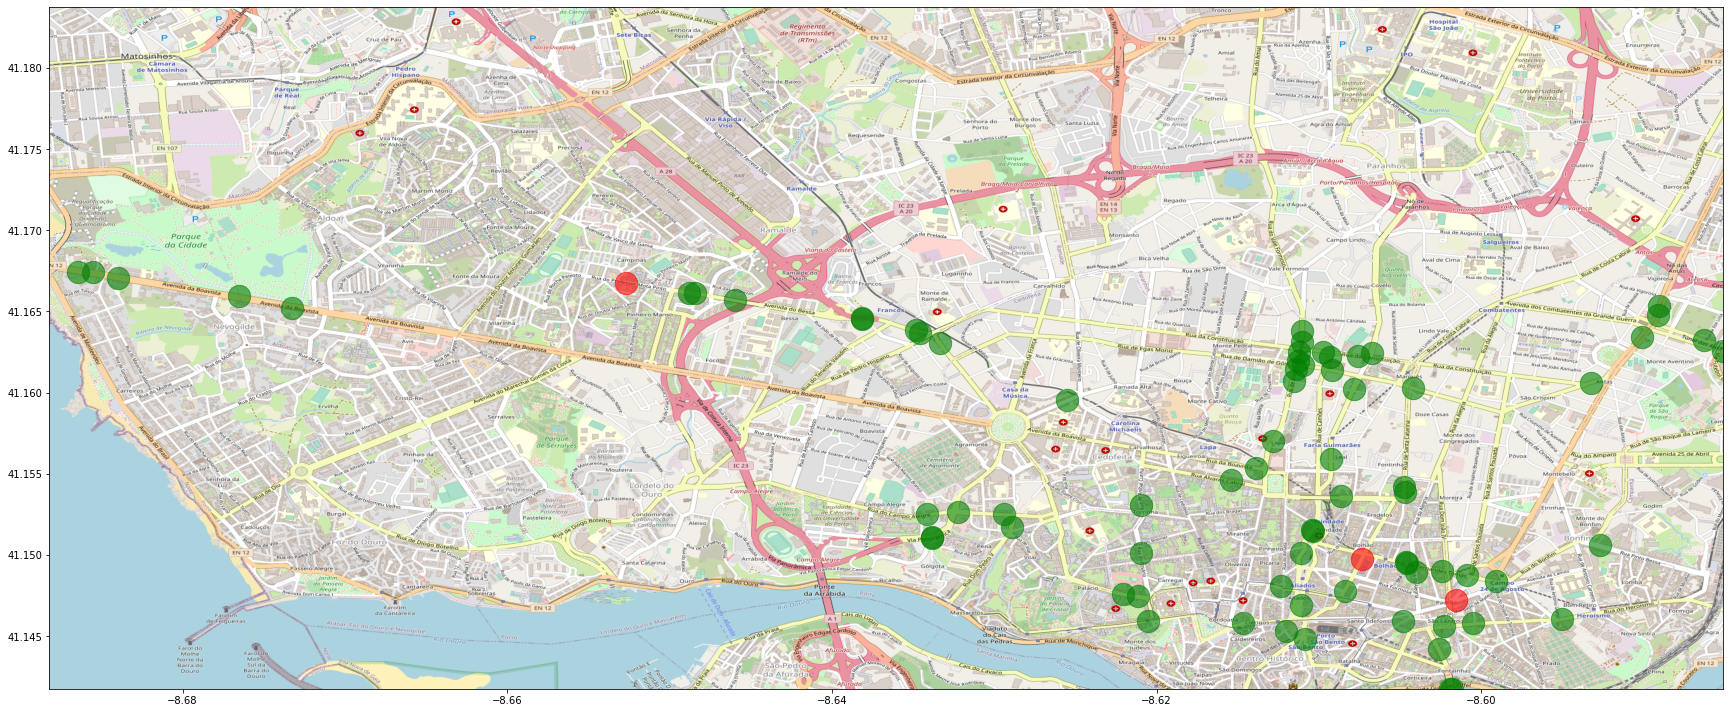

In [47]:
BBox = ((entities.longitude.min(),   entities.longitude.max(),      
         entities.latitude.min(), entities.latitude.max()))

fig, ax = plt.subplots(figsize = (30,30))

r = requests.get('https://raw.githubusercontent.com/fernandeslouro/wdl-data/main/map.png')
ruh_m = plt.imread(BytesIO(r.content))

ax.scatter(to_plot[to_plot.preds_over_mean<1].longitude, to_plot[to_plot.preds_over_mean<1].latitude, zorder=1, alpha=0.6 , c='g', s=500)

ax.scatter(to_plot[to_plot.preds_over_mean>1].longitude, to_plot[to_plot.preds_over_mean>1].latitude, zorder=1, alpha=0.6 , c='r', s=500)

ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')


It would be interesting to present this plot with the transparecy value corresponding to the value of (1-preds_over_mean). It's interesting to see that for this day the model is predicting lower traffic than usual for most places, but there are two or three places where traffic is expected to be more than usual. This information would be very useful when choosing actions to perform.

# Textual Information

In [42]:
print(f'The following streets can be expected to have more traffic than usual on {DAY}:')
for i in to_plot[to_plot.preds_over_mean>1].sort_values('preds_over_mean', ascending= False).name.tolist():
    print(i)

The following streets can be expected to have more traffic than usual on 2021-03-29:
R. Sá da Bandeira - Fernandes Tomás
R. Santo Ildefonso - Coelho Neto
R.Prof.Mota Pinto - O-E


## Conclusions

### Scalability and Impact
This approach scales very well. For a larger city, it would only require increasing the number of car counters.

### Future Work

We didn't get to use the whole data, so trying to develop bigger models with more past data would be our initial next steps. Including data and features for specific holidays (like christmas time) would also be quite important, since these times often mean increases in traffic.

Our approach could benefit from features connecting different car counters together. For example, we could have traffic information in past days for the closer sensors. This would surely benefit our predictions.
At a certain point, it may be beneficial to have different models for areas with different traffic patters, or even models for single sensors.
Studying additional sources of data, or even experimenting with the whole data that was provided (noise and air quality information) is of course a promising line of work as well.